In [1]:
%cd ..

/mnt/raid/spirit/eduardo/General-GPT


In [2]:
import os
import requests
import json

import clip
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers.optimization import get_linear_schedule_with_warmup

import numpy as np
import pandas as pd
from PIL import Image
import skimage.io as io
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from pycocotools.coco import COCO

[2023-11-04 16:54:54,691] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
model_name = "ViT-L/14"
clip_model, preprocess = clip.load(model_name, device=device) # output dim of 768
clip_model.to(device).eval();

In [7]:
def batch_encode(image_dir: str, output_dir: str = "../coco_embs", batch_size: int = 64) -> None:
    image_tensors = []

    for i in tqdm(range(0, len(os.listdir(image_dir)), batch_size)):
        images = []

        with torch.no_grad():
            for filename in os.listdir(image_dir)[i:i+batch_size]: 
                images.append(preprocess(Image.open(os.path.join(image_dir, filename))).unsqueeze(0))

            image_tensors.append(clip_model.encode_image(torch.cat(images, dim=0).to(device)).detach().cpu())

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    np.save(
        f"{output_dir}/coco_train2017_clip_{model_name.replace('/', '-')}_embs.npy", 
        torch.cat(image_tensors, dim=0).numpy(), 
        allow_pickle=True
    )

In [ ]:
batch_encode(image_dir="../train2017", batch_size=512)

In [12]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [4]:
%%capture
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({"additional_special_tokens": ["[CLIP IN]", "[\CLIP IN]", "[CLIP OUT]", "[\CLIP OUT]"]})

model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
model.resize_token_embeddings(len(tokenizer))
model.eval()

In [5]:
coco_images = np.load("./coco_embs/coco_train2017_clip_ViT-L-14_embs.npy")
coco_images_tensor = torch.Tensor(coco_images)
print(coco_images_tensor.size())

torch.Size([118287, 768])


In [25]:
coco_images_tensor.dtype

torch.float32

In [6]:
class COCODataset(Dataset):
    def __init__(self, caption_file, image_dir):
        self.coco_captions = COCO(caption_file)

        self.files = os.listdir(image_dir)
        self.file_id_dict = {}
        self.coco_data = []

        # Create data tuples: (caption, image_id, CLIP embedding, index of embedding)
        for i, f in enumerate(self.files):
            file_id = int(f[:-4])
            self.file_id_dict[i] = file_id
            for ann_id in self.coco_captions.getAnnIds(imgIds=file_id):
                if np.random.random() < 0.5:
                    text = "Caption: [" + self.coco_captions.loadAnns(ids=ann_id)[0]["caption"].strip() + "]. [CLIP OUT][\CLIP OUT]"
                    clip_pos = -1
                else:
                    text = "[CLIP IN] [\CLIP IN] Caption: [" + self.coco_captions.loadAnns(ids=ann_id)[0]["caption"].strip() + "]."
                    clip_pos = 1

                self.coco_data.append(
                    (
                        text, 
                        self.coco_captions.loadAnns(ids=ann_id)[0]["image_id"],
                        coco_images_tensor[i].unsqueeze(0),
                        clip_pos
                    )
                )

    def __len__(self):
        return len(self.coco_data)

    def __getitem__(self, idx):
        return self.coco_data[idx]

In [21]:
for ann_id in coco_dataset.coco_captions.getAnnIds(imgIds=int(coco_dataset.files[0][:-4])):
    print(ann_id)

303064
304078
305122
305842
306136


In [23]:
coco_dataset.coco_captions.loadAnns(ids=ann_id)

[{'image_id': 283380,
  'id': 306136,
  'caption': 'an orange and black motorcycle parked next to some water'}]

In [7]:
coco_dataset = COCODataset(
    caption_file="./annotations/captions_train2017.json", 
    image_dir="./train2017/"
)

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [8]:
def collate_fn(batch):
    captions, img_ids, clip_embs, clip_pos = [], [], [], []
    for cap, im_id, emb, p in batch:
        captions.append(cap)
        img_ids.append(im_id)
        clip_embs.append(emb)
        clip_pos.append(p)
    
    clip_embs = torch.cat(clip_embs, dim=0)
    
    return captions, img_ids, clip_embs, clip_pos

('Caption: [An overhead view of a train sitting on the railroad tracks]. [CLIP OUT][\\CLIP OUT]', 116376)


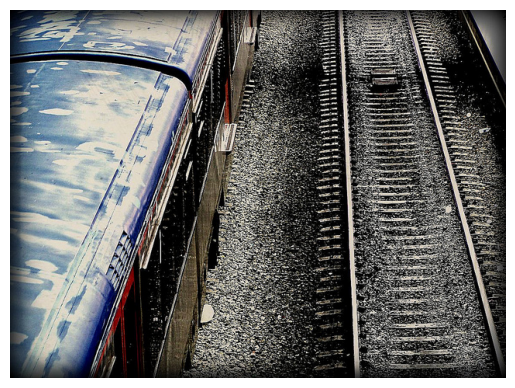

In [10]:
sample_id = 2547
print(coco_dataset.coco_data[sample_id][:2])
I = io.imread(coco_dataset.coco_captions.loadImgs(coco_dataset.coco_data[sample_id][1])[0]['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [11]:
def train_lm(model, tokenizer, caps, embs, clip_pos):
    # TODO: Optimize training
    
    criterion_ce = torch.nn.CrossEntropyLoss()
    criterion_mse = torch.nn.MSELoss()

    targets = tokenizer(caps, padding=True, return_tensors='pt', return_attention_mask=True)
    targets_ids = targets['input_ids'].to(device)
    targets_mask = targets['attention_mask'].to(device)

    token_embs = model.transformer.wte(targets_ids)

    # Create placeholder tensors to concatenate CLIP embeddings in the case of CLIP->caption
    input_clip_embs = torch.zeros((token_embs.size(0), token_embs.size(1)+1, token_embs.size(2)), device=device)
    target_clip_mask = torch.zeros((targets_mask.size(0), targets_mask.size(1)+1), dtype=torch.int64, device=device)
    target_clip_ids = torch.zeros((targets_ids.size(0), targets_ids.size(1)+1), dtype=torch.int64, device=device)

    embedding_ids = []  # Store indices of caption->CLIP examples
    captioning_ids = [] # Store indices of CLIP->caption examples
    for c in range(len(caps)):
        if clip_pos[c] < 0:
            embedding_ids.append(c)

            tok_count = torch.sum(targets_mask[c])
            pos = tok_count - abs(clip_pos[c])     # position of [\CLIP OUT] token, while ignoring variable padding 

            target_clip_ids[c] = torch.cat(
                (
                    targets_ids[c, :pos+1], torch.full((1,), fill_value=13).to(device), targets_ids[c, pos+1:]
                ), 
                dim=0
            ) # Add period token to match placeholder tensor size
            target_clip_mask[c, :tok_count+1] = 1

            with torch.no_grad():
                input_clip_embs[c] = torch.cat((token_embs[c, :pos+1], model.transformer.wte(torch.tensor([13]).to(device)).reshape(1, -1), token_embs[c, pos+1:]), dim=0)
                
        else:
            captioning_ids.append(c)
            pos = clip_pos[c]        # position of [\CLIP IN] token

            input_clip_embs[c] = torch.cat((token_embs[c, :pos], embs[c].reshape(1, -1).to(device), token_embs[c, pos:]), dim=0) # Add input CLIP embedding
            target_clip_ids[c] = torch.cat((targets_ids[c, :pos], torch.zeros((1,)).to(device), targets_ids[c, pos:]), dim=0)    # Add dummy token; is ignored in loss 
            target_clip_mask[c] = torch.cat((targets_mask[c, :pos], torch.ones((1,)).to(device), targets_mask[c, pos:]), dim=0)  # Avoid masking new token

    outputs = model(
        inputs_embeds=input_clip_embs,
        return_dict=True,
        output_hidden_states=True,
        attention_mask=target_clip_mask
    )

    # Fetch last layer's hidden_state for [\CLIP OUT] tokens
    last_hiddens = []
    for idx in embedding_ids:
        tok_count = torch.sum(targets_mask[idx])                      # Use original position since we concatenated an additional token
        pos = (tok_count - abs(clip_pos[idx])) - 1                    # Subtract 1 since we shift targets
        last_hiddens.append(outputs['hidden_states'][-1][idx][pos])
        
    caption_to_clip_loss = criterion_ce(outputs['logits'][embedding_ids, :-1].view(-1, outputs['logits'].size(-1)), target_clip_ids[embedding_ids, 1:].view(-1)) \
                            + criterion_mse(torch.stack(last_hiddens, dim=0).to(device), embs[embedding_ids].to(device))
    clip_to_caption_loss = torch.nn.functional.cross_entropy(outputs['logits'][captioning_ids, :-1].reshape(-1, outputs['logits'].size(-1)), targets_ids[captioning_ids].flatten(), ignore_index=0)

    loss = caption_to_clip_loss + clip_to_caption_loss

    return loss


def tune_caption_to_CLIP(model, tokenizer, optimizer, scheduler, dataloader, epochs=5):
    
    model.train()
    for epoch in range(epochs):
       
        print(f"Training epoch: {epoch}")
        num_batches = len(dataloader)

        for batch_idx, (caps, _, embs, clip_pos) in  tqdm(enumerate(dataloader)):

            optimizer.zero_grad()

            loss = train_lm(model, tokenizer, caps, embs, clip_pos)
            loss.backward()

            optimizer.step()
            scheduler.step()
            
            if batch_idx % 1000 == 0 and batch_idx != 0:
                print(f"Loss at batch {batch_idx} / {num_batches}  = {loss}")

In [ ]:
coco_dataloader = DataLoader(coco_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=2000, num_training_steps=epochs * len(coco_dataloader))

tune_caption_to_CLIP(model, tokenizer, optimizer, scheduler, coco_dataloader, epochs=epochs)